In [20]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [6]:
DATASET_PATH = os.path.join('datasets', 'titanic')


In [8]:
# load train & test titanic data to pandas df (Dataframe)

train_data = pd.read_csv(DATASET_PATH + '/train.csv')
test_data = pd.read_csv(DATASET_PATH + '/test.csv')

In [58]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [35]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [57]:
'''
0: DEAD
1: SURVIVED
'''
train_data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [46]:
train_data['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [48]:
'''
S: Southampton
C: Cherbourg
Q: QueensTown
'''
train_data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [49]:
'''
1: 1st class (Upper Income generally)
2: 2nd class (Middle Income generally)
3: 3rd class (Low Income generally)
'''
train_data['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12ce42400>,
      dtype=object)

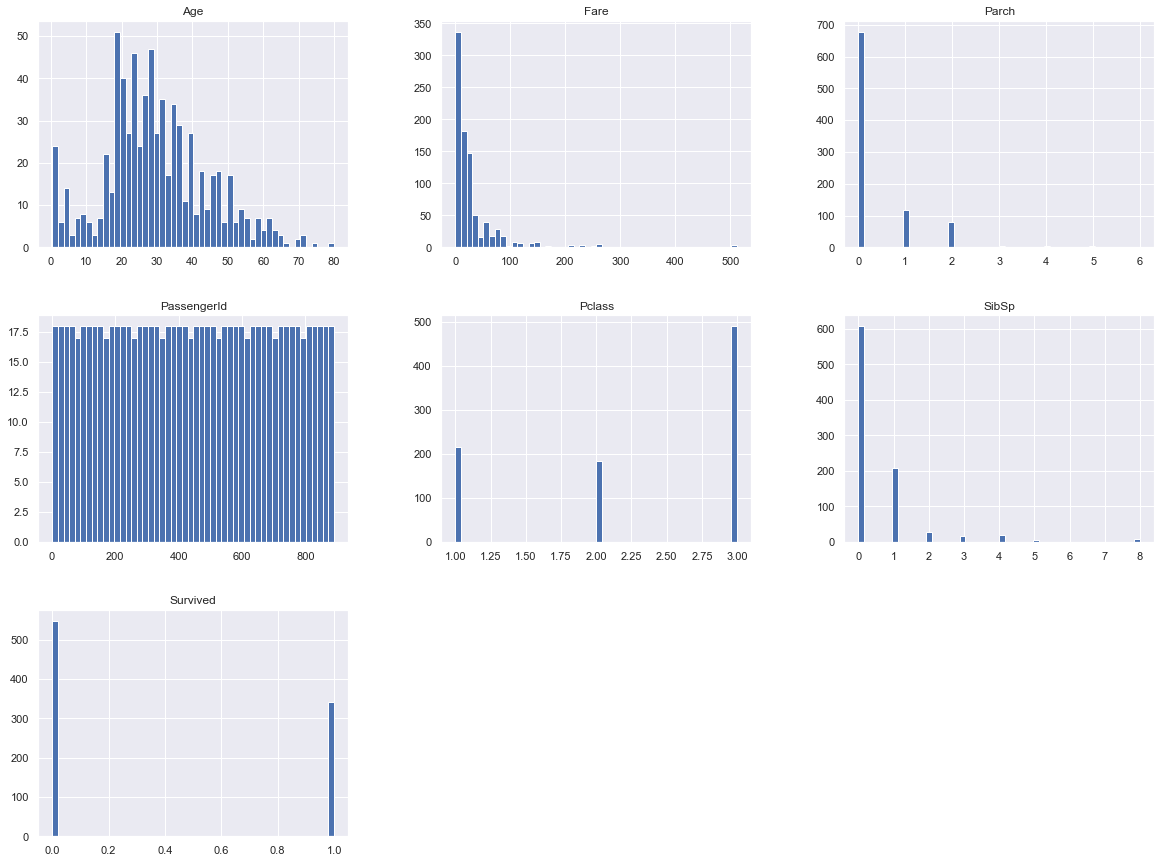

In [85]:
train_data.hist(bins=50, figsize=(20,15))

In [67]:
embarked_train = train_data[['Embarked']].copy()

# Dealing with Scikit-learn & pandas


**THIS PART is not releated to Titanic Analysis.
Showcasing preparing string type data to use with scikit-learn models**

### Example of preparing a column to be 2 dimensions from df
(Scikit-learn) expects 2D arrays to train against
This snippet show how to transofrm it to 2D

```python
train_data['Embarked'].value_counts()

S    644
C    168
Q     77

embarked_train = train_data[['Embarked']].copy()
embarked_train

	Embarked
0	S
1	C
2	S
3	S
4	S


```


### Scikit-learn API is consistent for all estimators. It uses a 3 step process to fit(train) the data. 

Below these instructions is an example on how to transform & encode a column that has values as string to be represented numerically.

## STEPS to prepare for fitting (training) the data

1. Import desired estimator from module it's in
2. Initilize estimator (change defaults if needed
3. Fit estimator to the data. (MUST not contain any Nan to be fitted)

We start by importing `OneHotEncoder` and intilize with `sparse=False` to ensure a dense array.

Then encode our single column with `fit_transform`

In [66]:
# 1. import estimator
from sklearn.preprocessing import OneHotEncoder

# 2. Intilize estimator
ohe = OneHotEncoder(sparse=False)

# 3. fit data to estimator
# embarked_train_transform = ohe.fit_transform(embarked_train)
# embarked_train_transform

# Continuing Titanic ML...
Building pipeline for numerical attributes (features)

In [70]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [82]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer # for scikit-learn 0.20 +

num_pipelines = Pipeline([
    ('select_numeric', DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
    ('imputer', SimpleImputer(strategy='median'))
])

In [88]:
num_pipelines.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

In [90]:
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [91]:
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [94]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [96]:
from sklearn.pipeline import FeatureUnion

preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipelines),
        ("cat_pipeline", cat_pipeline),
    ])

In [99]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

In [100]:
y_train = train_data['Survived']

In [101]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [102]:
X_test = preprocess_pipeline.fit_transform(test_data)
y_pred = svm_clf.predict(X_test)

In [104]:
from sklearn.model_selection import cross_val_score

svm_score = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_score.mean()

0.7365250822835092

array([0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,